In [ ]:
# Laster inn pakkene
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
import seaborn as sns
from scipy.stats import linregress

# Sette opp riktig innstillinger
pd.set_option('display.max_columns', 500)

# Kobler opp mot disken min for å lagre datasettene
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Henter datagrunnlaget

## Vannmagasin

In [ ]:
# Henter ut datagrunnlaget for vannbeholdnigene

## URL til API.
url = 'https://biapi.nve.no/magasinstatistikk/api/Magasinstatistikk/HentOffentligData'

# Klargjør datasettet i tabellform som skal brukes til senere arbeid.
parameters = {} # denne er tom for øyeblikket

# igjen, ingen parametere, men legger den til i tilefellet
# jeg skal gjøre det senere.
r = requests.get(url, params=parameters)
r.json()

# omgjør datasettet til dataframe eller to-dimensjonalt for analysering
vdf = pd.DataFrame(r.json())

vdf.sort_values('dato_Id')

,dato_Id,omrType,omrnr,iso_aar,iso_uke,fyllingsgrad,kapasitet_TWh,fylling_TWh,neste_Publiseringsdato,fyllingsgrad_forrige_uke,endring_fyllingsgrad
505,1995-01-08,EL,3,1995,1,0.603797,9.122690,5.508255,0001-01-01T00:00:00,0.669095,-0.065298
2206,1995-01-08,EL,1,1995,1,0.621467,6.003510,3.730985,0001-01-01T00:00:00,0.612609,0.008858
9495,1995-01-08,VASS,2,1995,1,0.608746,23.259571,14.159173,0001-01-01T00:00:00,0.490732,0.118014
4540,1995-01-08,EL,5,1995,1,0.616325,17.425789,10.739956,0001-01-01T00:00:00,0.687228,-0.070902
3259,1995-01-08,EL,2,1995,1,0.631010,33.991127,21.448732,0001-01-01T00:00:00,0.718118,-0.087108
...,...,...,...,...,...,...,...,...,...,...,...
13242,2024-04-07,VASS,2,2024,14,0.301698,23.259571,7.017366,2024-04-17T13:00:00,0.312474,-0.010776
7303,2024-04-07,EL,2,2024,14,0.367016,33.991127,12.475298,2024-04-17T13:00:00,0.375757,-0.008741
7089,2024-04-07,EL,5,2024,14,0.173245,17.425789,3.018924,2024-04-17T13:00:00,0.195132,-0.021888
13315,2024-04-07,VASS,1,2024,14,0.272603,36.005160,9.815122,2024-04-17T13:00:00,0.287335,-0.014731


## Nedbørdata

In [ ]:
# Henter ut all informasjon som omhandler rengfall.
geourl = 'https://frost.met.no/sources/v0.jsonld'
# henter ut informasjonen fra API, husk at her kan det være smart å avgrense til tid ettersom det er en mulighet i APIen?

ndfgeo = requests.get(geourl, auth= ('token', 'toke')) # denne hentes fra nettsiden til frost

# Pakker ut datagrunnlaget
ndfgeo = pd.json_normalize(ndfgeo.json()['data'])

In [ ]:
# Ettersom område 2 i NVE sin statistikk omhander sør-norge velger jeg det
# samme for nebørstat. slik at de to gir mening sammenligningen av
# nebør og vannbeholdningene i vannmagasinene.

# Legger inn alle fylkene som tilsvarer landsinndelingen til NVE
fylker = ['VESTFOLD', 'ROGALAND', 'TELEMARK', 'AGDER']

geosources = (
    str(ndfgeo.loc[lambda x: x['county'].isin(fylker)]['id']
        .unique().tolist()[0:50])[2:-2].replace("'", "")
)

In [ ]:
parameters = {
    #'sources': 'SN18700,SN90450', # En ide er å gjøre sånn at dennde IDen blir avgjort av datasettet med geografisk lokasjon.
    'sources': geosources, # Legg merke til at jeg henter ut alle basert på listen og områder jeg bestemte tidligere, bare opp 50!
    'elements': 'max(sum(precipitation_amount P1D) P1M), best_estimate_sum(precipitation_amount P1M)', # henter ut data om nedbør pr dag og mnd
    #'referencetime': '2022-04-01/2022-04-03', #legger til periode, men denne må avgrenses til ett bestmt år, helst 2022. Må også finne været
    'referencetime':'1995-01-01T00.00/2022-12-01T00' # henter ut foramteringen for dette området, https://frost.met.no/concepts2.html#timespecifications
}

# Heter datagrunnlaget
nedbort = requests.get(
    'https://frost.met.no/observations/v0.jsonld',
    parameters,
    auth= ('token', 'toke') # Denne hentes fra nettsiden til frost
)

# Pakker ut m. metadata
ndf = pd.json_normalize(
    nedbort.json()['data'], record_path = 'observations', meta = [
        'referenceTime', 'sourceId',
        ]
                  )

# Skriver data til disken min
ndfstat = ndf.astype('str') # omgjør til str for å ikke miste potensiell data
ndfstat.to_csv('/content/gdrive/MyDrive/Colab_Notebooks/Fraktal_caseoppgave/produksjonskode_m_data/nedbor_data.csv', index=False)

## Mindre rettinger i datagrunnlaget

In [ ]:
ndf1 = (
    ndf
    # Velger best_estimate_sum(precipitation_amount P1M) fordi
    # den er Homogenisert  som er justert for eventuelle feil eller
    # unøyaktigheter som kan ha oppstått i dataene.
    .loc[lambda x: x['elementId'] == "best_estimate_sum(precipitation_amount P1M)"]
    .assign(
        dato = lambda x: pd.to_datetime(x['referenceTime'].str.split('T', expand = True)[0]),
        month = lambda x: x['dato'].dt.month # ordner opp idatoer
        )
    .drop(columns = ['elementId', 'performanceCategory', 'exposureCategory']) # Fjerner overflødige kolonner
)
ndf1

,value,unit,timeOffset,timeResolution,timeSeriesId,qualityCode,referenceTime,sourceId,dato,month
130,225.4,mm,PT6H,P1M,0,2,2009-07-01T00:00:00.000Z,SN26990:0,2009-07-01,7
153,76.8,mm,PT6H,P1M,0,2,2011-05-01T00:00:00.000Z,SN26990:0,2011-05-01,5
155,143.6,mm,PT6H,P1M,0,2,2011-06-01T00:00:00.000Z,SN26990:0,2011-06-01,6
158,160.2,mm,PT6H,P1M,0,2,2011-08-01T00:00:00.000Z,SN26990:0,2011-08-01,8
163,111.6,mm,PT6H,P1M,0,2,2011-12-01T00:00:00.000Z,SN26990:0,2011-12-01,12
...,...,...,...,...,...,...,...,...,...,...
7277,84.8,mm,PT6H,P1M,0,2,2022-07-01T00:00:00.000Z,SN47230:0,2022-07-01,7
7279,126.4,mm,PT6H,P1M,0,2,2022-08-01T00:00:00.000Z,SN47230:0,2022-08-01,8
7281,102.1,mm,PT6H,P1M,0,2,2022-09-01T00:00:00.000Z,SN47230:0,2022-09-01,9
7283,142.9,mm,PT6H,P1M,0,2,2022-10-01T00:00:00.000Z,SN47230:0,2022-10-01,10


In [ ]:
# Ser på datagrunnlaget til vannmagasinene. Her tenker jeg at må filtrerer litt.

vdf1 = (
    vdf
    # Velger ut vann som områdetype og velger sør-Norge.
    .loc[lambda x: (x['omrType'] == "VASS") & (x['omrnr'] == 2)]
    .sort_values('dato_Id') # går tilbake til 1995
    .assign( # legger til/overskriver en rekke kolonner som jeg trenger til senere analyse.
        dato_Id = lambda x: pd.to_datetime(x['dato_Id']), # gjør dette for å legge til ny kolonne som henviser til mnd.
        month = lambda x: x['dato_Id'].dt.month, # legger til mnd for å summere min, max og median senere
        min_mnd = lambda x: x.groupby(['iso_aar', 'month'])['fyllingsgrad'].transform('min') * 100, # minste verdien i mnd inndelt etter område?
        maks_mnd = lambda x: x.groupby(['iso_aar', 'month'])['fyllingsgrad'].transform('max') * 100, # største verdien i mnd inndelt etter område?
        median_mnd = lambda x: x.groupby(['iso_aar', 'month'])['fyllingsgrad'].transform('median') * 100 # median i mnd inndelt etter område?
             )
)

vdf1

,dato_Id,omrType,omrnr,iso_aar,iso_uke,fyllingsgrad,kapasitet_TWh,fylling_TWh,neste_Publiseringsdato,fyllingsgrad_forrige_uke,endring_fyllingsgrad,month,min_mnd,maks_mnd,median_mnd
9495,1995-01-08,VASS,2,1995,1,0.608746,23.259571,14.159173,0001-01-01T00:00:00,0.490732,0.118014,1,54.233450,60.874610,57.922155
11509,1995-01-15,VASS,2,1995,2,0.588155,23.259571,13.680242,0001-01-01T00:00:00,0.608746,-0.020591,1,54.233450,60.874610,57.922155
12318,1995-01-22,VASS,2,1995,3,0.570288,23.259571,13.264647,0001-01-01T00:00:00,0.588155,-0.017868,1,54.233450,60.874610,57.922155
12811,1995-01-29,VASS,2,1995,4,0.542335,23.259571,12.614468,0001-01-01T00:00:00,0.570288,-0.027953,1,54.233450,60.874610,57.922155
11813,1995-02-05,VASS,2,1995,5,0.519736,23.259571,12.088846,0001-01-01T00:00:00,0.542335,-0.022598,2,45.123370,51.973647,48.671161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13742,2024-03-10,VASS,2,2024,10,0.376106,23.259571,8.748061,2024-03-20T13:00:00,0.401787,-0.025681,3,31.247386,40.178695,35.535887
13237,2024-03-17,VASS,2,2024,11,0.355359,23.259571,8.265494,2024-03-27T13:00:00,0.376597,-0.021239,3,31.247386,40.178695,35.535887
13240,2024-03-24,VASS,2,2024,12,0.331060,23.259571,7.700313,2024-04-03T13:00:00,0.355359,-0.024299,3,31.247386,40.178695,35.535887
13244,2024-03-31,VASS,2,2024,13,0.312474,23.259571,7.268008,2024-04-10T13:00:00,0.331060,-0.018586,3,31.247386,40.178695,35.535887


In [ ]:
## Oppretter datasett med tidsstempel og inndeling etter mnd samt opprydding
# vdf['iso_aar'].value_counts().plot(kind='bar') # God fordeling mellom antall registreringer, men må avgrense denne grunnet manglende registrerigner i enbor data etter 2018

oppssvann = (
    vdf
    .loc[lambda x: (x['iso_aar'] > 2018) & (x['iso_aar'] < 2023) & (x['omrType'] == "VASS") & (x['omrnr'] == 2)] # Velger ut riktig tidsrom og områdetype
    .drop(columns = ['omrType', 'neste_Publiseringsdato']) # Velger ut kolonnen jeg tenker er hensiktsmessig å velge
    .assign( # legger til summeringer som jeg tenker er viktig å ha med seg i analysen
        dato_Id = lambda x: pd.to_datetime(x['dato_Id']),
        month = lambda x: x['dato_Id'].dt.month,
        min_fyllingsgrad_month = lambda x: x.groupby(['iso_aar', 'month'])['fyllingsgrad'].transform('min'), # minste verdien i mnd inndelt etter område?
        maks_fyllingsgrad_month = lambda x: x.groupby(['iso_aar', 'month'])['fyllingsgrad'].transform('max'), # største verdien i mnd inndelt etter område?
        median_fyllingsgrad_month = lambda x: x.groupby(['iso_aar', 'month'])['fyllingsgrad'].transform('median') # median i mnd inndelt etter område?
    )
    .sort_values(['iso_aar', 'month'])
    .drop_duplicates(subset = ['iso_aar', 'month'], keep = 'last')
)

oppssnedbor = (
    ndf
    .query('elementId == "best_estimate_sum(precipitation_amount P1M)"')
    .filter(items = ['referenceTime', 'sourceId', 'value'])
    .assign(
        dato = lambda x: pd.to_datetime(x['referenceTime'].str.split('T', expand = True)[0]),
        year = lambda x: pd.to_datetime(x['referenceTime']).dt.year, # omgjør til dato og henter ut året
        month = lambda x: pd.to_datetime(x['referenceTime']).dt.month
    )
    .filter(items = ['dato', 'year', 'month', 'value'])
    .assign(
        min_nedbor_month = lambda x: x.groupby(['year', 'month'])['value'].transform('min'), # minste verdien i mnd inndelt etter område?
        maks_nedbor_month = lambda x: x.groupby(['year', 'month'])['value'].transform('max'), # største verdien i mnd inndelt etter område?
        median_nedbor_month = lambda x: x.groupby(['year', 'month'])['value'].transform('median'), # median i mnd inndelt etter område?
        mean_nedbor_month = lambda x: x.groupby(['year', 'month'])['value'].transform('mean'),
        sum_nedbor_month = lambda x: x.groupby(['year', 'month'])['value'].transform('sum')
    )
    .loc[lambda x: (x['year'] > 2018) & (x['year'] < 2023)]
    .sort_values(['year', 'month'])
    .drop_duplicates(subset = ['year', 'month'], keep = 'last')
)

arbdata = oppssvann.merge(oppssnedbor, left_on = ['iso_aar', 'month'], right_on = ['year', 'month'], how = 'left')

# skrivearbdf = arbdata.astype('str') # omgjør til str for å ikke miste potensiell data
# skrivearbdf.to_csv('/content/gdrive/MyDrive/Colab_Notebooks/Fraktal_caseoppgave/produksjonskode_m_data/Magasin_arb.csv', index=False)

arbdata

,dato_Id,omrnr,iso_aar,iso_uke,fyllingsgrad,kapasitet_TWh,fylling_TWh,fyllingsgrad_forrige_uke,endring_fyllingsgrad,month,min_fyllingsgrad_month,maks_fyllingsgrad_month,median_fyllingsgrad_month,dato,year,value,min_nedbor_month,maks_nedbor_month,median_nedbor_month,mean_nedbor_month,sum_nedbor_month
0,2019-01-13,2,2019,2,0.679920,23.259571,15.814653,0.699357,-0.019436,1,0.616035,0.699357,0.665818,2019-01-01,2019.0,40.8,8.5,207.6,74.20,82.366667,1976.8
1,2019-02-17,2,2019,7,0.541169,23.259571,12.587358,0.555274,-0.014105,2,0.531400,0.582174,0.548221,2019-02-01,2019.0,70.2,38.9,186.7,96.30,101.011538,2626.3
2,2019-03-03,2,2019,9,0.516593,23.259571,12.015733,0.531400,-0.014807,3,0.468020,0.516593,0.479017,2019-03-01,2019.0,145.4,60.6,316.9,128.45,149.123077,3877.2
3,2019-04-21,2,2019,16,0.421886,23.259571,9.812875,0.433419,-0.011533,4,0.421886,0.455038,0.443170,2019-04-01,2019.0,1.0,0.2,45.4,33.35,27.600000,717.6
4,2019-05-05,2,2019,18,0.477568,23.259571,11.108020,0.455038,0.022530,5,0.468425,0.523345,0.477092,2019-05-01,2019.0,49.8,40.2,167.4,84.30,86.592000,2164.8
5,2019-06-23,2,2019,25,0.674090,23.259571,15.679044,0.639411,0.034679,6,0.540506,0.695440,0.639411,2019-06-01,2019.0,94.9,68.4,226.1,110.60,118.196296,3191.3
6,2019-07-07,2,2019,27,0.723010,23.259571,16.816904,0.695440,0.027570,7,0.720341,0.735764,0.722818,2019-07-01,2019.0,106.8,48.9,230.6,103.60,98.277778,2653.5
7,2019-08-25,2,2019,34,0.789656,23.259571,18.367050,0.759023,0.030633,8,0.737917,0.789656,0.748779,2019-08-01,2019.0,181.1,94.7,473.7,159.40,192.207407,5189.6
8,2019-09-08,2,2019,36,0.825305,23.259571,19.196230,0.816372,0.008933,9,0.816372,0.867717,0.856475,2019-09-01,2019.0,158.9,82.7,370.7,190.60,202.300000,5057.5
9,2019-10-13,2,2019,41,0.845717,23.259571,19.671024,0.843349,0.002369,10,0.837528,0.847506,0.844533,2019-10-01,2019.0,184.1,114.3,355.5,177.75,188.363636,4144.0


## Utforsking av datagrunnlaget

In [ ]:
# Ser på antall registreringer over tid for å sikre god data bak i historikken
def plot_series(series, series_name):
    palette = list(sns.color_palette("Dark2"))
    counted = series['dato'].value_counts().reset_index(name='counts').rename({'index': 'dato'}, axis=1).sort_values('dato', ascending=True)
    xs = counted['dato']
    ys = counted['counts']
    return go.Scatter(x=xs, y=ys, mode='lines', name=series_name, line=dict(color= 'red'))

# Opprett figur
fig = go.Figure()

# Legg til data
df_sorted = ndf1.sort_values('dato', ascending=True)
fig.add_trace(plot_series(df_sorted, ''))

# Oppdater layout
fig.update_layout(
    title="Tellinger/ frekvensen på dato i datatypen",
    xaxis_title="Dato",
    yaxis_title="Frekvens"
)

# Vis figur
fig.show()

In [ ]:
# Ser på nebør over tid, husk svake data fra 2018 og tilbake!

def plot_series(series, series_name, series_index=0):
    palette = list(sns.color_palette("Dark2"))  # Velger en fargepalett
    xs = series['dato']  # X-aksen: datoer
    ys = series['value']  # Y-aksen: verdier
    return go.Scatter(x=xs, y=ys, mode='lines', name=series_name, line=dict(color='red'))  # Returnerer et spor for plottet

# Opprett figur
fig = go.Figure()

# Legg til data
df_sorted = ndf1.sort_values('dato', ascending=True)  # Sorterer data etter dato
fig.add_trace(plot_series(df_sorted, ''))  # Legger til data i plottet

# Oppdater layout
fig.update_layout(
    title="Antall registreringer over tid",  # Tittel på plottet
    xaxis_title="Dato",  # Tittel på x-aksen
    yaxis_title="Value"  # Tittel på y-aksen
)

# Vis figur
fig.show()

In [ ]:
# Definer spredningsdiagram-data
scatter_data = go.Scatter(x=vdf1['iso_uke'], y=vdf1['fyllingsgrad'], mode='markers', marker=dict(size=16, opacity=0.8))

# Beregn lineær regresjon
slope, intercept, _, _, _ = linregress(vdf1['iso_uke'], vdf1['fyllingsgrad'])
x_values = np.array([min(vdf1['iso_uke']), max(vdf1['iso_uke'])])
y_values = slope * x_values + intercept

# Definer lm-linje-data
lm_line = go.Scatter(x=x_values, y=y_values, mode='lines', name='LM Linje')

# Opprett figur og legg til data
fig = go.Figure(data=[scatter_data, lm_line])

# Oppdater layout
fig.update_layout(
    title="Utvikling av fyllingsgrad over ett kalenderår - historisk",  # Tittel på plottet
    xaxis_title="Uker",  # Tittel på x-aksen
    yaxis_title="Fyllingsgrad",  # Tittel på y-aksen
    showlegend=True,  # Vis tegnforklaring
    xaxis=dict(showline=True, showgrid=False, showticklabels=True),  # Justeringer for x-aksen
    yaxis=dict(showline=True, showgrid=False, showticklabels=True),  # Justeringer for y-aksen
    margin=dict(l=40, r=30, t=40, b=30)  # Marginaljusteringer
)

# Vis figur
fig.show()

<Axes: title={'center': 'Fyllingsgrad observasjoner i datasette'}>

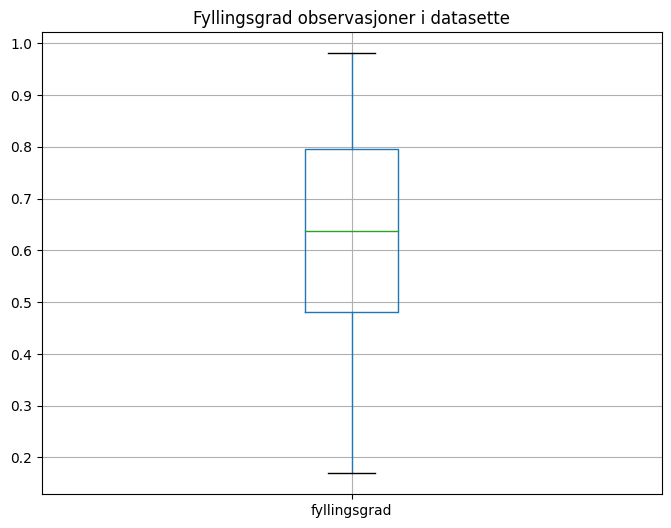

In [ ]:
# Ser på ekstreme verdier i vannheoldningsdatasettet
fig = plt.figure(figsize=(8,6))
ax = fig.gca()
plt.title("Fyllingsgrad observasjoner i datasette")
vdf.loc[lambda x: (x['omrType'] == "VASS") & (x['omrnr'] == 2)].boxplot(column=['fyllingsgrad'], ax=ax)

<Axes: title={'center': 'Fyllingsgrad Terrawattimer observasjoner i datasette'}>

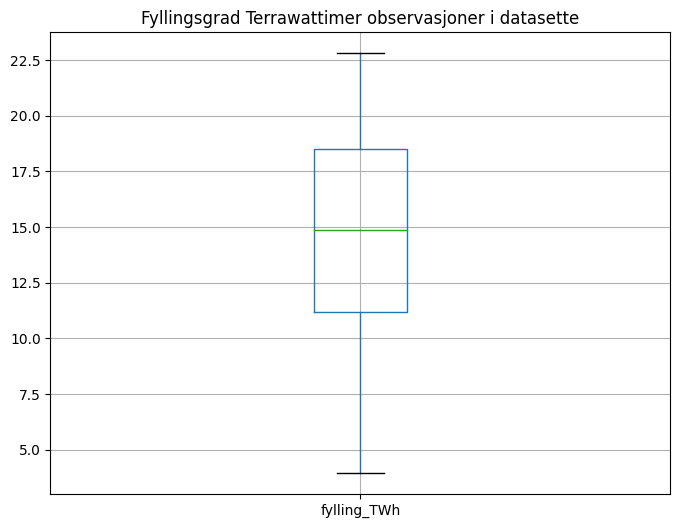

In [ ]:
# Ser på ekstreme verdier i vannheoldningsdatasettet
fig = plt.figure(figsize=(8,6))
ax = fig.gca()
plt.title("Fyllingsgrad Terrawattimer observasjoner i datasette")
vdf.loc[lambda x: (x['omrType'] == "VASS") & (x['omrnr'] == 2)].boxplot(column=['fylling_TWh'], ax=ax)

<Axes: title={'center': 'Nenbør observasjoner'}>

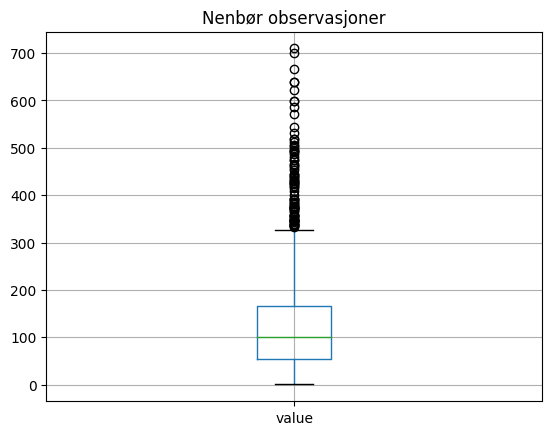

In [ ]:
plt.title("Nenbør observasjoner")
ndf.loc[lambda x: x['elementId'] == "best_estimate_sum(precipitation_amount P1M)"].filter(items= ['value', 'referenceTime']).boxplot(column = 'value')

# Visualiseringer

In [ ]:
vdf1

,dato_Id,omrType,omrnr,iso_aar,iso_uke,fyllingsgrad,kapasitet_TWh,fylling_TWh,neste_Publiseringsdato,fyllingsgrad_forrige_uke,endring_fyllingsgrad,month,min_mnd,maks_mnd,median_mnd
9495,1995-01-08,VASS,2,1995,1,0.608746,23.259571,14.159173,0001-01-01T00:00:00,0.490732,0.118014,1,54.233450,60.874610,57.922155
11509,1995-01-15,VASS,2,1995,2,0.588155,23.259571,13.680242,0001-01-01T00:00:00,0.608746,-0.020591,1,54.233450,60.874610,57.922155
12318,1995-01-22,VASS,2,1995,3,0.570288,23.259571,13.264647,0001-01-01T00:00:00,0.588155,-0.017868,1,54.233450,60.874610,57.922155
12811,1995-01-29,VASS,2,1995,4,0.542335,23.259571,12.614468,0001-01-01T00:00:00,0.570288,-0.027953,1,54.233450,60.874610,57.922155
11813,1995-02-05,VASS,2,1995,5,0.519736,23.259571,12.088846,0001-01-01T00:00:00,0.542335,-0.022598,2,45.123370,51.973647,48.671161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13742,2024-03-10,VASS,2,2024,10,0.376106,23.259571,8.748061,2024-03-20T13:00:00,0.401787,-0.025681,3,31.247386,40.178695,35.535887
13237,2024-03-17,VASS,2,2024,11,0.355359,23.259571,8.265494,2024-03-27T13:00:00,0.376597,-0.021239,3,31.247386,40.178695,35.535887
13240,2024-03-24,VASS,2,2024,12,0.331060,23.259571,7.700313,2024-04-03T13:00:00,0.355359,-0.024299,3,31.247386,40.178695,35.535887
13244,2024-03-31,VASS,2,2024,13,0.312474,23.259571,7.268008,2024-04-10T13:00:00,0.331060,-0.018586,3,31.247386,40.178695,35.535887


In [ ]:
vdf1.assign(medium = lambda x: x.groupby(['iso_aar', 'month'])['fyllingsgrad'].transform('median') * 100).round(2)

,dato_Id,omrType,omrnr,iso_aar,iso_uke,fyllingsgrad,kapasitet_TWh,fylling_TWh,neste_Publiseringsdato,fyllingsgrad_forrige_uke,endring_fyllingsgrad,month,min_mnd,maks_mnd,median_mnd,medium
9495,1995-01-08,VASS,2,1995,1,0.61,23.26,14.16,0001-01-01T00:00:00,0.49,0.12,1,54.23,60.87,57.92,57.92
11509,1995-01-15,VASS,2,1995,2,0.59,23.26,13.68,0001-01-01T00:00:00,0.61,-0.02,1,54.23,60.87,57.92,57.92
12318,1995-01-22,VASS,2,1995,3,0.57,23.26,13.26,0001-01-01T00:00:00,0.59,-0.02,1,54.23,60.87,57.92,57.92
12811,1995-01-29,VASS,2,1995,4,0.54,23.26,12.61,0001-01-01T00:00:00,0.57,-0.03,1,54.23,60.87,57.92,57.92
11813,1995-02-05,VASS,2,1995,5,0.52,23.26,12.09,0001-01-01T00:00:00,0.54,-0.02,2,45.12,51.97,48.67,48.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13742,2024-03-10,VASS,2,2024,10,0.38,23.26,8.75,2024-03-20T13:00:00,0.40,-0.03,3,31.25,40.18,35.54,35.54
13237,2024-03-17,VASS,2,2024,11,0.36,23.26,8.27,2024-03-27T13:00:00,0.38,-0.02,3,31.25,40.18,35.54,35.54
13240,2024-03-24,VASS,2,2024,12,0.33,23.26,7.70,2024-04-03T13:00:00,0.36,-0.02,3,31.25,40.18,35.54,35.54
13244,2024-03-31,VASS,2,2024,13,0.31,23.26,7.27,2024-04-10T13:00:00,0.33,-0.02,3,31.25,40.18,35.54,35.54


In [ ]:
import plotly.express as px
hist_median = (
    vdf1
    .filter(items = ['month', 'median_mnd', 'fyllingsgrad', 'iso_aar'])
    .loc[lambda x: x['iso_aar'] == 2022]
    .groupby('month')['fyllingsgrad'].mean().reset_index()
    .rename(columns = {'fyllingsgrad': 'fyllingsgrad_2022_median'})
    .assign(fyllingsgrad_2022_median = lambda x: x['fyllingsgrad_2022_median'] * 100)
    .merge(
        (
    vdf
    .assign( # legger til/overskriver en rekke kolonner som jeg trenger til senere analyse.
            dato_Id = lambda x: pd.to_datetime(x['dato_Id']), # gjør dette for å legge til ny kolonne som henviser til mnd.
             month = lambda x: x['dato_Id'].dt.month,
             year = lambda x: x['dato_Id'].dt.year
             )
    .query('year < 2022')
    .sort_values('year')
    .groupby('month')['fyllingsgrad'].mean().reset_index()
    .rename(columns = {'fyllingsgrad': 'fyllingsgrad_hist_median'})
    .assign(fyllingsgrad_hist_median = lambda x: x['fyllingsgrad_hist_median'] * 100).round(2)
), on = 'month')
)

# hist_median

# # Plotter grafen
(
    hist_median
    .pipe(lambda x: px.bar(x, x='month', y='fyllingsgrad_2022_median', title='Gjennomsnittelig fyllingsgrad med historisk sammenligning'))
    .update_traces(marker_color='lightblue', selector=dict(type='bar'))  # Endrer farge på stolpene til blå
    .add_trace(
        px.line(hist_median, x='month', y='fyllingsgrad_hist_median').data[0]  # Legger til linjeplot med rød linje
    )
    .update_layout(
        xaxis_title="Måneder",  # Endrer navnet på x-aksen
        yaxis_title="Fyllingsgrad (prosent)",  # Endrer navnet på y-aksen
        )
)

In [ ]:

fig = px.bar(hist_median, x='month', y='fyllingsgrad_2022_median', title='Median av fyllingsgrad med historisk sammenligning')
fig.update_traces(texttemplate='%{y:.2f}', textposition='outside', marker_color='lightblue')


fig.add_trace(
    px.line(hist_median, x='month', y='fyllingsgrad_hist_median').update_traces(texttemplate='%{y:.2f}', textposition='top center').data[0]
)


fig.update_layout(
    xaxis=dict(tickmode='array', tickvals=hist_median['month'], ticktext=hist_median['month']),
    xaxis_title="Måneder",
    yaxis_title="Fyllingsgrad (prosent)",
    showlegend=False
)


fig.show()


In [ ]:
hist_median1 = (
    hist_median
    .assign(deviation = lambda x: x['fyllingsgrad_2022_median'] - x['fyllingsgrad_hist_median'])
)


fig = px.bar(hist_median1, x='month', y='fyllingsgrad_2022_median', title='Gjennomsnittelig fyllingsgrad med historisk sammenligning og avvik')
fig.update_traces(texttemplate='%{y:.2f}', textposition='outside', marker_color='lightblue')


fig.add_trace(
    px.line(hist_median1, x='month', y='fyllingsgrad_hist_median').update_traces(texttemplate='%{y:.2f}', textposition='top center').data[0]
)


for idx, row in hist_median1.iterrows():
    fig.add_annotation(
        x=row['month'], y=row['fyllingsgrad_hist_median'],
        text=f'Avvik: {row["deviation"]:.2f}',
        showarrow=True,
        arrowhead=1,
        yshift=10
    )


fig.update_layout(
    xaxis=dict(tickmode='array', tickvals=hist_median1['month'], ticktext=hist_median1['month']),
    xaxis_title="Måneder",
    yaxis_title="Fyllingsgrad (prosent)",
    showlegend=False
)


fig.show()


In [ ]:
(
    vdf1
    .filter(items = ['dato_Id', 'omrnr', 'omrType', 'fyllingsgrad', 'fyllingsgrad_forrige_uke', 'endring_fyllingsgrad', 'iso_aar'])
    .query('iso_aar == 2022')
    .assign(måned = lambda x: pd.to_datetime(x['dato_Id']).dt.month)
    .groupby('måned')['endring_fyllingsgrad'].mean().reset_index()
    .pipe(lambda x: px.bar(x, x='måned', y='endring_fyllingsgrad', title='Gjennomsnittelig endring i fyllingsgrad per måned for året 2022'))
    .update_layout(
        xaxis_title="Måneder",  # Endrer navnet på x-aksen
        yaxis_title="Endringer i fyllingsgrad",  # Endrer navnet på y-aksen
        )
    .show()
)

In [ ]:
(
    vdf1
    .filter(items=['dato_Id', 'omrnr', 'omrType', 'fyllingsgrad', 'fyllingsgrad_forrige_uke', 'endring_fyllingsgrad', 'iso_aar'])
    .assign(måned=lambda x: pd.to_datetime(x['dato_Id']).dt.month)
    .groupby('måned')['endring_fyllingsgrad'].mean().reset_index()
    .assign(endring_fyllingsgrad = lambda x: x['endring_fyllingsgrad'] * 100)
)

,måned,endring_fyllingsgrad
0,1,-1.988509
1,2,-2.362841
2,3,-2.229883
3,4,-1.362204
4,5,1.302779
5,6,4.072658
6,7,2.970646
7,8,1.193077
8,9,0.594919
9,10,0.323154


In [ ]:
import pandas as pd
import plotly.express as px

# Anta at vdf1 er forberedt som en pandas DataFrame tidligere i koden
# Her er en eksempelvis tilpasning basert på din forespørsel

data = (
    vdf1
    .filter(items=['dato_Id', 'omrnr', 'omrType', 'fyllingsgrad', 'fyllingsgrad_forrige_uke', 'endring_fyllingsgrad', 'iso_aar'])
    .query('iso_aar == 2022')
    .assign(måned=lambda x: pd.to_datetime(x['dato_Id']).dt.month)
    .groupby('måned')['endring_fyllingsgrad'].mean().reset_index()
    .assign(endring_fyllingsgrad = lambda x: x['endring_fyllingsgrad'] * 100)
        .merge(
        (
    vdf1
    .filter(items=['dato_Id', 'omrnr', 'omrType', 'fyllingsgrad', 'fyllingsgrad_forrige_uke', 'endring_fyllingsgrad', 'iso_aar'])
    .assign(måned=lambda x: pd.to_datetime(x['dato_Id']).dt.month)
    .groupby('måned')['endring_fyllingsgrad'].mean().reset_index()
    .assign(endring_fyllingsgrad = lambda x: x['endring_fyllingsgrad'] * 100)
    .rename(columns = {'endring_fyllingsgrad': 'endring_fyllingsgrad_hist'})
    ), on = 'måned'
    )
)

# Opprette barplot med tilpasset farge
fig = px.bar(
    data,
    x='måned',
    y='endring_fyllingsgrad',
    title='Endring i fyllingsgrad per måned for året 2022',
    text='endring_fyllingsgrad',  # Legger til tekst på stolpene
    color='endring_fyllingsgrad',  # Setter farge basert på verdien
    color_continuous_scale=['lightcoral', 'lightblue']  # Rød for negative, blå for positive
)

# Oppdaterer tekstposisjonen og layout
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(
    xaxis_title="Måneder",
    yaxis_title="Total endringer i fyllingsgrad",
    coloraxis_showscale=False  # Skjuler fargeskalaen om ønskelig
)

# Viser figuren
fig.show()


In [ ]:
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px


data = (
    vdf1
    .filter(items=['dato_Id', 'omrnr', 'omrType', 'fyllingsgrad', 'fyllingsgrad_forrige_uke', 'endring_fyllingsgrad', 'iso_aar'])
    .assign(måned=lambda x: pd.to_datetime(x['dato_Id']).dt.month, år=lambda x: pd.to_datetime(x['dato_Id']).dt.year)
    .groupby(['år', 'måned'])['endring_fyllingsgrad'].mean().reset_index()
    .assign(endring_fyllingsgrad=lambda x: x['endring_fyllingsgrad'] * 100)
)

# Splitte data inn i 2022 og historisk
data_2022 = data.query('år == 2022')
data_hist = data.query('år < 2022').groupby('måned')['endring_fyllingsgrad'].mean().reset_index().rename(columns={'endring_fyllingsgrad': 'endring_fyllingsgrad_hist'})

# Merge 2022 data med historisk gjennomsnitt
data = pd.merge(data_2022, data_hist, on='måned')

# Opprette figur med barplot for 2022 og linjeplot for historisk data
fig = go.Figure()

# Barplot for 2022 data
fig.add_trace(go.Bar(
    x=data['måned'],
    y=data['endring_fyllingsgrad'],
    name='2022 Endringer',
    text=data['endring_fyllingsgrad'],
    textposition='outside',
    texttemplate='%{text:.2f}',  # Formatterer tekst til å vise to desimaler
    marker_color=px.colors.qualitative.Pastel1[1]  # Lyseblå
))

# Linjeplot for historisk gjennomsnitt
fig.add_trace(go.Scatter(
    x=data['måned'],
    y=data['endring_fyllingsgrad_hist'],
    name='Historisk Gjennomsnitt',
    mode='lines+markers+text',
    text=data['endring_fyllingsgrad_hist'],
    textposition='top center',
    texttemplate='%{text:.2f}'  # Formatterer tekst til å vise to desimaler
))

# Oppdatere layout for å inkludere tittelen og aksenavnene og vise alle måneder
fig.update_layout(
    title='Endring i fyllingsgrad per måned for året 2022 med historisk sammenligning',
    xaxis=dict(
        title='Måneder',
        tickmode='linear',
        tick0=1,
        dtick=1
    ),
    yaxis_title='Endring i fyllingsgrad (%)',
    legend_title='Beskrielse'
)

# Vis figuren
fig.show()


In [ ]:
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])

# Fyllingsgrad
fig.add_trace(go.Scatter(x=arbdata['iso_aar'].astype(str)+ '-' + arbdata['month'].astype(str),
                         y=arbdata['median_fyllingsgrad_month'],
                         name='Fyllingsgrad (Median)',
                         mode='lines+markers',
                         line=dict(color='blue')), secondary_y=False)

# Nedbør
fig.add_trace(go.Scatter(x=arbdata['iso_aar'].astype(str)+ '-' + arbdata['month'].astype(str),
                         y=arbdata['median_nedbor_month'],
                         name='Nedbør (median)',
                         mode='lines+markers',
                         line=dict(color='green')), secondary_y=True)


fig.update_layout(title='Historisk utvikling av fyllingsgrad og nedbør',
                  xaxis_title='Dato',
                  yaxis_title='Fyllingsgrad (median)',
                  legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))
fig.update_yaxes(title_text="Nedbør mm (Median)", secondary_y=True)


fig.show()

In [ ]:
arbdata[['fyllingsgrad', 'value']].corr()

,fyllingsgrad,value
fyllingsgrad,1.000000,0.187917
value,0.187917,1.000000
